In [1]:
import sys
sys.path.append('../utils')
from nd_tools import scale_img

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans


The goals of this notebook is to:

1. Introduce coherence images
2. Use coherence images for classification

# Inspecting Data

In [2]:
data_dir = Path('../data')
coh_tifs = sorted(list(data_dir.glob('./*coh*.tif')))
coh_tifs

[PosixPath('../data/alos_coh_hh.tif'), PosixPath('../data/alos_coh_hv.tif')]

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

coherence_bands = list(map(open_one, coh_tifs))

Text(0.5, 1.0, 'HH Coherence')

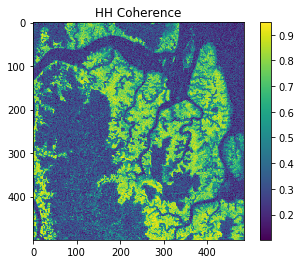

In [4]:
plt.imshow(coherence_bands[0])
plt.colorbar()
plt.title('HH Coherence')

Text(0.5, 1.0, 'HV Coherence')

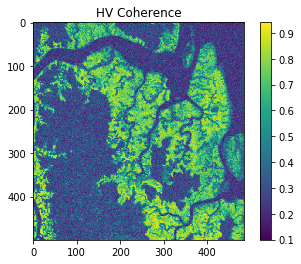

In [5]:
plt.imshow(coherence_bands[1])
plt.colorbar()
plt.title('HV Coherence')

Coherence is a measure of [complex correlation](https://earth.esa.int/handbooks/asar/CNTR5-2.html#eph.asar.gloss.radsar:COHERENCE) within a given window. Above, the coherence images are from [ALOS-2](https://www.eorc.jaxa.jp/ALOS/en/index.htm) and processed using the open-source [ISCE2](https://github.com/isce-framework/isce2). A nice tutorial on how to obtain coherence images from ALOS with ISCE can be found [here](https://github.com/isce-framework/isce2-docs/blob/b3c618e57a3b349b8d2f143e96547edc0864e936/Notebooks/Stripmap/stripmapApp.ipynb).

We see indeed the correlation lies between 0 and 1.

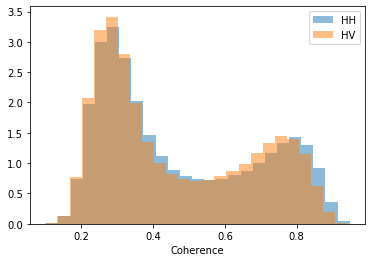

In [6]:
plt.hist(coherence_bands[0].ravel(),
         bins=25,
         density=True,
         label='HH',
         alpha=.5)
plt.hist(coherence_bands[1].ravel(),
         bins=25,
         density=True,
         label='HV',
         alpha=.5)
plt.xlabel('Coherence')
plt.legend()

Let's see what happens when we classify the coherence image with k-means.

In [7]:
model = KMeans(n_clusters=3, 
               random_state=0)
X_train = np.zeros((coherence_bands[0].size, 2))
X_train[:, 0] = coherence_bands[0].ravel()
X_train[:, 1] = coherence_bands[1].ravel()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

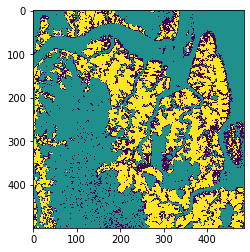

In [8]:
classes = model.labels_.reshape(coherence_bands[0].shape)
plt.imshow(classes)

Clearly the forest and ocean are conflated. Let's add backscatter to the classification.

# Combining Coherence and Backscatter for Classification

In [9]:
data_dir = Path('../data')
tv_tifs = sorted(list(data_dir.glob('./*tv.tif')))
tv_tifs

[PosixPath('../data/alos_hh_tv.tif'), PosixPath('../data/alos_hv_tv.tif')]

In [10]:
backscatter_bands = list(map(open_one, tv_tifs))

In [11]:
model = KMeans(n_clusters=3, 
               random_state=0)
X_train = np.zeros((coherence_bands[0].size, 4))
X_train[:, 0] = coherence_bands[0].ravel()
X_train[:, 1] = coherence_bands[1].ravel()
X_train[:, 2] = backscatter_bands[0].ravel()
X_train[:, 3] = backscatter_bands[1].ravel()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

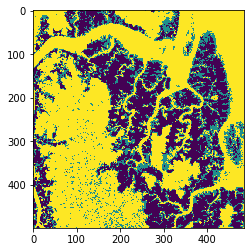

In [12]:
classes = model.labels_.reshape(backscatter_bands[0].shape)
plt.imshow(classes)

# Excercise 1

Improve the classification by scaling each band to be between 0 and 1. Why does this help? Where are the problem points? Try using 4 classes, too.

Save to GTiff and inspect.

In [13]:
## Answer

all_bands = backscatter_bands + coherence_bands
all_bands = list(map(scale_img, all_bands))

In [14]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
for k in range(len(all_bands)):
    X_train[:, k] = all_bands[k].ravel()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

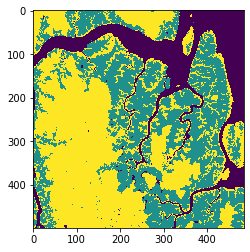

In [15]:
## Answer

classes = model.labels_.reshape(backscatter_bands[0].shape)
plt.imshow(classes)

In [16]:
## Answer

with rasterio.open(tv_tifs[0]) as ds:
    profile = ds.profile

profile['dtype'] = 'int32'
profile['nodata'] = None
with rasterio.open('classes.tif', 'w', **profile) as ds:
    ds.write(classes, 1)

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna) and [Werapong Koedsin](http://werapong-g.space.psu.ac.th/). We also thank the [SARI](http://sari.umd.edu/) and [LCLUC](https://lcluc.umd.edu/) programs, especially [Garik Gutman](https://lcluc.umd.edu/people/garik-gutman), making such trainings possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
